In [1]:
import numpy as np
import xarray as xr
import dask
import warnings

In [17]:
import matplotlib.pyplot as plt

In [81]:
ds = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/hot/ACCESS-ESM1-5_tas.nc')
ds_isi = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/native_grid/avg/CanESM5.nc')

In [66]:
ds = ds.sel(lat=40.109665, lon=360-88.204247, method='nearest')
ds_isi = ds_isi.sel(lat=40.109665, lon=-88.204247, method='nearest')

In [ ]:
ds_rolling = xr.polyval(coord = ds['time'],
                        coeffs = ds.polyfit(dim='time', deg=4, skipna=False))
ds_isi_rolling = xr.polyval(coord = ds_isi['time'],
                            coeffs = ds_isi.polyfit(dim='time', deg=4, skipna=False))

In [ ]:
ds['time'] = ds['time'].dt.year
ds_rolling['time'] = ds_rolling['time'].dt.year

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ds.sel(lat=40.109665, lon=360-88.204247, method='nearest').tas_q99gmfd_streak.plot(hue='ssp', ax=ax[0])
ds_rolling.sel(lat=40.109665, lon=360-88.204247, method='nearest').tas_q99gmfd_streak_polyfit_coefficients.plot(hue='ssp', ax=ax[1])
plt.show()

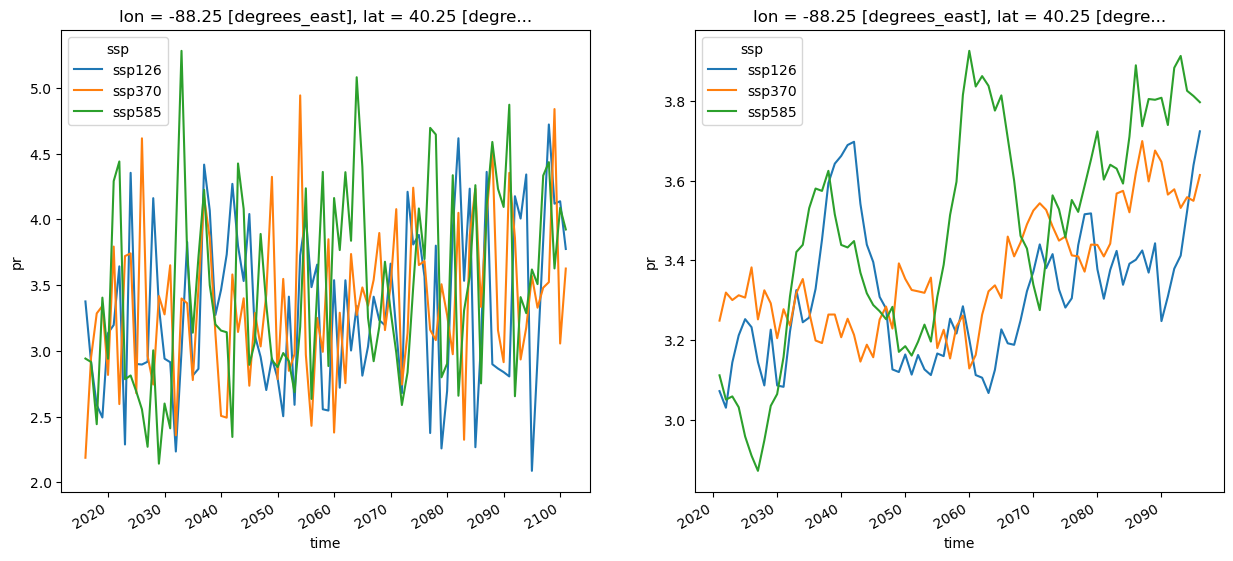

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ds_isi.pr.plot(hue='ssp', ax=ax[0])
ds_isi_rolling.pr.plot(hue='ssp', ax=ax[1])
plt.show()

### Preliminaries

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
nex_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/'
cil_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/'
isi_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/'
cbp_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/carbonplan/'

out_path = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/'

In [3]:
###################
# Models
###################
from utils import nex_ssp_dict, cil_ssp_dict, isimip_ssp_dict, gardsv_ssp_dict, gardsv_var_dict, deepsdbc_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if 'pr' in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

In [4]:
#######################
# Land mask (from NEX)
#######################
land_mask = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/avg/CanESM5.nc')
land_mask = land_mask.isel(ssp=0, time=0).tas.isnull()
land_mask['lon'] = np.where(land_mask['lon'] > 180, land_mask['lon'] - 360, land_mask['lon'])
land_mask = land_mask.sortby('lon')

In [5]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=1, memory='50GB', resource_spec='pmem=50GB',
                     # account='open',
                     worker_extra_args=['#PBS -l feature=rhel7'], 
                     walltime='00:25:00')

cluster.scale(jobs=30)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.237:42092,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Total uncertainty

### Function definition

In [6]:
#######################################################################
# Total uncertainty: variance across all models, scenarios, ensembles 
#######################################################################
def uc_total(nex_in, nex_models, 
             cil_in, cil_models, 
             isi_in, isi_models, 
             cbp_in, cbp_gard_models, cbp_deep_models,
             land_mask,
             metric, submetric,
             year):
    """
    Reads in all models, ssps, and calculates the total uncertainty (variance across
    all model, ssp, ensemble dimensions) for a given year (and possibly DataArray).
    For metrics like 'hot' where there are several sub-metrics based on different 
    thresholds and/or observational data, we need to select a specific DataArray
    to keep the memory manageable.
    """
    # Subfunction for general preprocessing of each model/ensemble
    def read_and_process(ensemble, path_in, model, year, metric, submetric):
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
            
        
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = ensemble)
        ds = ds.sel(lat=slice(-60, 90))
        
        # Add model dimension
        if model[-6:] in ['tasmin', 'tasmax']:
            model_str = model[:-7]
        else:
            model_str = model
        ds = ds.assign_coords(model = model_str)
        
        # Fix lon to [-180,180]
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
    
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds.data_vars):
            ds['pr'] = xr.full_like(ds[list(ds.data_vars)[0]], np.nan)
    
        # Return
        return ds

    ######################
    # Read all ensembles
    ######################
    # NEX-GDDP 
    ds_out = []
    for model in nex_models:
        ds_out.append(read_and_process('NEX', nex_in, model, year, metric, submetric))
    ds_nex = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # CIL-GDPCIR
    ds_out = []
    for model in cil_models:
        ds_out.append(read_and_process('CIL', cil_in, model, year, metric, submetric))
    ds_cil = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # ISIMIP
    ds_out = []
    for model in isi_models:
        ds_out.append(read_and_process('ISIMIP', isi_in, model, year, metric, submetric))
    ds_isi = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # carbonplan: GARD-SV
    ds_out = []
    for model in cbp_gard_models:
        ds_out.append(read_and_process('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, year, metric, submetric))
    ds_cbp_gard = xr.concat(ds_out, dim='model', fill_value=np.nan)
    
    # carbonplan: DeepSD-BC
    ds_out = []
    for model in cbp_deep_models:
        ds_out.append(read_and_process('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, year, metric, submetric))
    ds_cbp_deep = xr.concat(ds_out, dim='model', fill_value=np.nan)

    ###########################
    # Merge all and mask ocean
    ###########################
    ds = xr.concat([ds_nex, ds_cil, ds_isi, ds_cbp_gard, ds_cbp_deep],
                       dim='ensemble', fill_value=np.nan)

    # Mask out ocean points
    ds = xr.where(land_mask, np.nan, ds)
    
    ##########################
    # Uncertainty calculation
    ##########################
    ## Total uncertainty
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        U_total_true = ds.var(dim=['ensemble', 'ssp', 'model']) # throws warning when all NaNs

    U_total_true = U_total_true.assign_coords(uncertainty = 'total_true')
    
    return U_total_true

## Annual averages

In [10]:
%%time

metric = 'avg'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '.nc')

CPU times: user 58.7 s, sys: 4.14 s, total: 1min 2s
Wall time: 5min 32s


## 1-day maxs

In [11]:
%%time

metric = 'max'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric +'.nc')

CPU times: user 58.8 s, sys: 3.85 s, total: 1min 2s
Wall time: 5min 31s


## 5-day max (pr)

In [9]:
%%time

metric = 'max5d'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric +'.nc')

CPU times: user 55.6 s, sys: 3.15 s, total: 58.7 s
Wall time: 5min 15s


## Dry days

In [7]:
%%time

metric = 'dry'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric +'.nc')

CPU times: user 1min 28s, sys: 8.53 s, total: 1min 37s
Wall time: 10min 48s


## Wet days

In [7]:
%%time
# Wet days: 5yr RP
metric = 'wet'
submetric = ['pr_rp5gmfd_count', 'pr_rp5gmfd_streak']

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                     land_mask,
                                     metric, submetric,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '_rp5gmfd.nc')

CPU times: user 8.75 s, sys: 2.43 s, total: 11.2 s
Wall time: 5min 5s


## Hot days

In [7]:
%%time
# Hot days: 5yr RP GMFD tasmin
metric = 'hot'
submetric = ['tasmin_rp5gmfd_count', 'tasmin_rp5gmfd_streak']
submetric_var = 'tasmin'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, [model + '_' + submetric_var for model in nex_models], 
                                     cil_in, cil_models, 
                                     isi_in, [model + '_' + submetric_var for model in isi_models], 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, submetric, 
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '_' + submetric_var + '_rp5gmfd.nc')

CPU times: user 47.6 s, sys: 3.48 s, total: 51.1 s
Wall time: 5min 25s


In [7]:
%%time
# Hot days: tasmax 5yr GMFD RP
metric = 'hot'
submetric = ['tasmax_rp5gmfd_count', 'tasmax_rp5gmfd_streak']
submetric_var = 'tasmax'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, [model + '_' + submetric_var for model in nex_models], 
                                     cil_in, cil_models, 
                                     isi_in, [model + '_' + submetric_var for model in isi_models], 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, submetric, 
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '_' + submetric_var + '_rp5gmfd.nc')

CPU times: user 48.6 s, sys: 3.33 s, total: 51.9 s
Wall time: 5min 58s


In [8]:
ds = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/uc_results/total_uncertainty/hot_tasmax_rp5gmfd.nc')

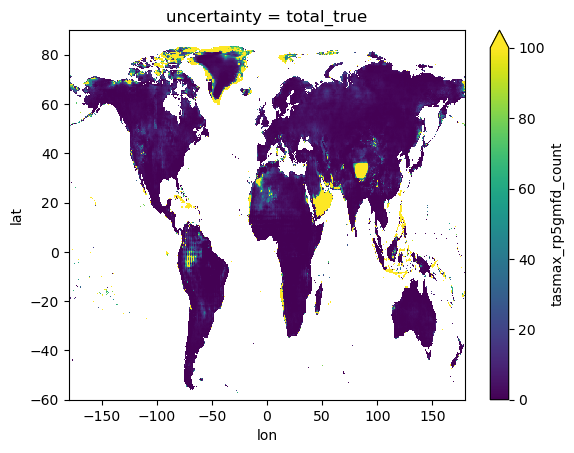

In [11]:
ds.tasmax_rp5gmfd_count.isel(time=10).plot(vmin=0, vmax=100)

# UC without interannual variability

In [5]:
################################################################
# Uncertainty characterization following Hawkins & Sutton 2009 
# No consideration of internal variability!
################################################################
def uc_no_iav(nex_in, nex_models, 
              cil_in, cil_models, 
              isi_in, isi_models, 
              cbp_in, cbp_gard_models, cbp_deep_models,
              metric, year):
    ##################################
    # Read and format all ensembles
    ##################################
    # NEX-GDDP 
    ds_out = []
    for model in nex_models:
        ds = xr.open_dataset(nex_in + metric + '/' + model + '.nc')
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
        ds = ds.sortby('lon')
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = 'NEX')
        ds = ds.assign_coords(model = ds.encoding['source'].replace(nex_in, '').split('/')[-1][:-3])
        ds_out.append(ds)
    ds_nex = xr.concat(ds_out, dim='model', compat='identical')

    # CIL-GDPCIR
    ds_out = []
    for model in cil_models:
        ds = xr.open_dataset(cil_in + metric + '/' + model, engine='zarr')
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds = ds.sel(lat=slice(-60, 90))
        ds = ds.assign_coords(ensemble = 'CIL')
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(model = ds.encoding['source'].replace(cil_in, '').split('/')[-1])
        ds_out.append(ds)
    ds_cil = xr.concat(ds_out, dim='model', compat='identical')

    # ISIMIP
    ds_out = []
    for model in isi_models:
        ds = xr.open_dataset(isi_in + metric + '/' + model + '.nc')
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
        ds = ds.sortby('lon')
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = 'ISIMIP')
        ds = ds.assign_coords(model = ds.encoding['source'].replace(isi_in, '').split('/')[-1][:-3])
        ds_out.append(ds)
    ds_isi = xr.concat(ds_out, dim='model', compat='identical')

    # carbonplan: GARD-SV
    ds_out = []
    for model in cbp_gard_models:
        ds = xr.open_dataset(cbp_in + 'GARD-SV/' + metric + '/' + model + '.nc')
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds = ds.sel(lat=slice(-60, 90))
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = 'GARD-SV')
        ds = ds.assign_coords(model = ds.encoding['source'].replace(cbp_in, '').split('/')[-1][:-3])
        # for some models/methods we are missing 
        # precip so need to fill with NaNs
        if 'pr' not in ds.data_vars:
            ds['pr'] = xr.full_like(ds['tas'], np.NaN)
        ds_out.append(ds)
    ds_cbp_gard = xr.concat(ds_out, dim='model', compat='identical')
    
    # carbonplan: DeepSD-BC
    ds_out = []
    for model in cbp_deep_models:
        ds = xr.open_dataset(cbp_in + 'DeepSD-BC/' + metric + '/' + model + '.nc')
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds = ds.sel(lat=slice(-60, 90))
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = 'DeepSD-BC')
        ds = ds.assign_coords(model = ds.encoding['source'].replace(cbp_in, '').split('/')[-1][:-3])
        # for some models/methods we are missing 
        # precip so need to fill with NaNs
        if 'pr' not in ds.data_vars:
            ds['pr'] = xr.full_like(ds['tas'], np.NaN)
        ds_out.append(ds)
    ds_cbp_deep = xr.concat(ds_out, dim='model', compat='identical')

    ###########################
    # Merge all and mask ocean
    ###########################
    ds = xr.concat([ds_nex, ds_cil, ds_isi, ds_cbp_gard, ds_cbp_deep],
                       dim='ensemble', fill_value=np.nan)
    
    # mask out ocean points (NEX is only available over land)
    ds_mask = ds.sel(ensemble='NEX').isel(ssp=0, model=0)[list(ds.keys())[0]].isnull()
    ds = xr.where(ds_mask, np.nan, ds)
    
    ##########################
    # Uncertainty calculation
    ##########################
    ##  Model uncertainty
    # Variance across models, averaged over scenarios and ensembles
    U_model = ds.var(dim='model')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='model').rename('weights') # weights (choose point over land)
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_model = U_model.weighted(weights).mean(dim=['ssp', 'ensemble']) # weighted average

    ## Scenario uncertainty
    # HS09 approach: variance across multi-model means
    U_scen_hs09 = ds.mean(dim=['model', 'ensemble']).var(dim='ssp')
    # BB13 approach: variance across scenarios, averaged over models and ensembles (no weighting)
    U_scen_bb13 = ds.var(dim='ssp').mean(dim=['model', 'ensemble'])

    ## Downscaling uncertainy
    # Variance across ensembles, averaged over models and scenarios
    U_ens = ds.var(dim='ensemble')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='ensemble').rename('weights') # weights
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_ens = U_ens.weighted(weights).mean(dim=['ssp', 'model'])

    ## Total uncertainty    
    # Our 'simulated' total uncertainty
    # This will in general not equal true total
    U_total = U_model + U_scen + U_ens

    ## Merge and return
    U_model = U_model.assign_coords(uncertainty = 'model')
    U_scen_hs09 = U_scen_hs09.assign_coords(uncertainty = 'scenario_hs09')
    U_scen_bb13 = U_scen_bb13.assign_coords(uncertainty = 'scenario_bb13')
    U_ens = U_ens.assign_coords(uncertainty = 'ensemble')
    U_total = U_total_sim.assign_coords(uncertainty = 'total')
    
    return xr.concat([U_model, U_scen, U_ens, U_total, U_total], dim='uncertainty')

## Annual averages

In [12]:
metric = 'avg'

In [13]:
%%time
################################
# UC on raw outputs (no iav)
################################
delayed_res = []
for year in range(2015, 2101):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_no_iav)(nex_in, nex_models, 
                                    cil_in, cil_models, 
                                    isi_in, isi_models, 
                                    cbp_in, cbp_gard_models, cbp_deep_models,
                                    metric, year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_no_iav/' + metric +'.nc')

## Annual maxs

In [8]:
metric = 'max'

In [8]:
%%time
################################
# UC on raw outputs (no iav)
################################
delayed_res = []
for year in range(2015, 2101):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_no_iav)(nex_in, nex_models, 
                                    cil_in, cil_models, 
                                    isi_in, isi_models, 
                                    cbp_in, cbp_gard_models, cbp_deep_models,
                                    metric, year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_no_iav/' + metric +'.nc')

CPU times: user 15.4 s, sys: 9.44 s, total: 24.8 s
Wall time: 7min 10s


# UC with interannual variability

### Function definitions

In [8]:
################################################################
# Uncertainty characterization following Hawkins & Sutton 2009 
# 'Forced response' = 10 year rolling mean
################################################################
def uc_forced(nex_in, nex_models,
              cil_in, cil_models, 
              isi_in, isi_models, 
              cbp_in, cbp_gard_models, cbp_deep_models,
              land_mask,
              metric, submetric, 
              year):
    """
    Reads in all models, ssps, and calculates the uncertainty in the 'forced response'
    (10 year rolling mean) along each dimension for a given year (and possibly DataArray).
    For metrics like 'hot' where there are several sub-metrics based on different 
    thresholds and/or observational data, we need to select a specific DataArray
    to keep the memory manageable.
    """
    # Subfunction for general preprocessing of each model/ensemble
    def read_and_process(ensemble, path_in, model, year, metric, submetric):
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
            
        
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=slice(year-5, year+5)) # faster rolling mean
        ds = ds.rolling(time=11, center=True).mean().sel(time=year)
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = ensemble)
        ds = ds.assign_coords(model = model)
        ds = ds.sel(lat=slice(-60, 90))
    
        # Fix lon to [-180,180]
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
    
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds.data_vars):
            ds['pr'] = xr.full_like(ds[list(ds.data_vars)[0]], np.nan)
    
        # Return
        return ds

    ######################
    # Read all ensembles
    ######################
    # NEX-GDDP 
    ds_out = []
    for model in nex_models:
        ds_out.append(read_and_process('NEX', nex_in, model, year, metric, submetric))
    ds_nex = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # CIL-GDPCIR
    ds_out = []
    for model in cil_models:
        ds_out.append(read_and_process('CIL', cil_in, model, year, metric, submetric))
    ds_cil = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # ISIMIP
    ds_out = []
    for model in isi_models:
        ds_out.append(read_and_process('ISIMIP', isi_in, model, year, metric, submetric))
    ds_isi = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # carbonplan: GARD-SV
    ds_out = []
    for model in cbp_gard_models:
        ds_out.append(read_and_process('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, year, metric, submetric))
    ds_cbp_gard = xr.concat(ds_out, dim='model', fill_value=np.nan)
    
    # carbonplan: DeepSD-BC
    ds_out = []
    for model in cbp_deep_models:
        ds_out.append(read_and_process('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, year, metric, submetric))
    ds_cbp_deep = xr.concat(ds_out, dim='model', fill_value=np.nan)

    ###########################
    # Merge all and mask ocean
    ###########################
    ds = xr.concat([ds_nex, ds_cil, ds_isi, ds_cbp_gard, ds_cbp_deep],
                       dim='ensemble', fill_value=np.nan)
    ds = xr.where(land_mask, np.nan, ds)
    
    ##########################
    # Uncertainty calculation
    ##########################
    ##  Model uncertainty
    # Variance across models, averaged over scenarios and ensembles
    U_model = ds.var(dim='model')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='model').rename('weights') # weights (choose point over land)
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_model = U_model.weighted(weights).mean(dim=['ssp', 'ensemble']) # weighted average

    ## Scenario uncertainty
    # HS09 approach: variance across multi-model means
    U_scen_hs09 = ds.mean(dim=['model', 'ensemble']).var(dim='ssp')
    # BB13 approach: variance across scenarios, averaged over models and ensembles (no weighting)
    U_scen_bb13 = ds.var(dim='ssp').mean(dim=['model', 'ensemble'])

    ## Downscaling uncertainy
    # Variance across ensembles, averaged over models and scenarios
    U_ens = ds.var(dim='ensemble')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='ensemble').rename('weights') # weights
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_ens = U_ens.weighted(weights).mean(dim=['ssp', 'model'])

    ## Merge and return
    U_model = U_model.assign_coords(uncertainty = 'model')
    U_scen_hs09 = U_scen_hs09.assign_coords(uncertainty = 'scenario_hs09')
    U_scen_bb13 = U_scen_bb13.assign_coords(uncertainty = 'scenario_bb13')
    U_ens = U_ens.assign_coords(uncertainty = 'ensemble')
    
    return xr.concat([U_model, U_scen, U_ens], dim='uncertainty')

In [9]:
################################################################
# Uncertainty characterization following Hawkins & Sutton 2009 
# Interannual variability (single value for all years)
################################################################
def uc_iav(path_in, ensemble, model, land_mask, metric, submetric):
    """
    Calculates the internal variability (variance over all years
    of residuals from rolling mean) for a given model-ssp-ensemble
    """
    # Subfunction for general preprocessing of each model/ensemble
    def read_and_process(ensemble, path_in, model, metric, submetric):
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
            
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds['time'] = ds.indexes['time'].year
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensmod = ensemble + '__' + model)
        ds = ds.sel(lat=slice(-60, 90))
    
        # Fix lon to [-180,180]
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
    
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds.data_vars):
            ds['pr'] = xr.full_like(ds[list(ds.data_vars)[0]], np.nan)
    
        # Return
        return ds

    ###############
    # Read model
    ###############
    ds = read_and_process(ensemble, path_in, model, metric, submetric)
    # Mask out ocean points
    ds = xr.where(land_mask, np.nan, ds)
            
    #####################################
    # Get IAV estimate
    # Variance of rolling mean residuals
    #####################################
    ds_rolling = ds.rolling(time=11, center=True).mean().sel(time=slice(2020,2094))
    return (ds - ds_rolling).var(dim='time')


def make_delayed_list_iav(metric, submetric, submetric_var):
    """
    Make a delayed list with IAV of all models-ssps-ensembles which 
    can then be combined into one dataset and averaged for best estimate.
    """
    # Parallelize with dask over models
    delayed_res = []
    
    # NEX
    if submetric_var:
        models = [model + '_' + submetric_var for model in nex_models]
    else:
        models = nex_models
    for model in models:
        tmp_res = dask.delayed(uc_iav)(nex_in, 'NEX', model, land_mask, metric, submetric)
        delayed_res.append(tmp_res)
        
    # CIL
    for model in cil_models:
        tmp_res = dask.delayed(uc_iav)(cil_in, 'CIL', model, land_mask, metric, submetric)
        delayed_res.append(tmp_res)
        
    # ISIMIP
    if submetric_var:
        models = [model + '_' + submetric_var for model in isi_models]
    else:
        models = isi_models
    for model in models:
        tmp_res = dask.delayed(uc_iav)(isi_in, 'ISIMIP', model, land_mask, metric, submetric)
        delayed_res.append(tmp_res)
        
    # carbonplan GARD-SV
    if metric in ['wet', 'dry', 'max5d']:
        models = cbp_gard_precip_models
    else:
        models = cbp_gard_models
        
    for model in models:
        tmp_res = dask.delayed(uc_iav)(cbp_in + '/regridded/conservative/GARD-SV/', 'GARD-SV', model, land_mask, metric, submetric)
        delayed_res.append(tmp_res)
        
    # carbonplan DeepSD-BC
    for model in cbp_deep_models:
        tmp_res = dask.delayed(uc_iav)(cbp_in + 'native_grid/DeepSD-BC/', 'DeepSD-BC', model, land_mask, metric, submetric)
        delayed_res.append(tmp_res)
        
    # return
    return delayed_res

## Annual averages

In [26]:
metric = 'avg'

In [27]:
%%time
################################
# Interannual variability
################################
delayed_res = make_delayed_list_iav(metric, False, False)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and average over ensemble + model (ensmod) and ssp
ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_iav.nc')

CPU times: user 42.6 s, sys: 6.51 s, total: 49.1 s
Wall time: 2min 39s


In [28]:
%%time
################################
# UC on forced response
################################
delayed_res = []
for year in range(2020, 2095):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_forced)(nex_in, nex_models, 
                                           cil_in, cil_models, 
                                           isi_in, isi_models, 
                                           cbp_in, cbp_gard_models, cbp_deep_models,
                                           land_mask,
                                           metric, False,
                                           year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '.nc')

CPU times: user 2min 35s, sys: 14.1 s, total: 2min 49s
Wall time: 13min 55s


## 1-day max

In [29]:
metric = 'max'

In [30]:
%%time
################################
# Interannual variability
################################
delayed_res = make_delayed_list_iav(metric, False, False)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and average over ensemble + model (ensmod) and ssp
ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_iav.nc')

CPU times: user 49.1 s, sys: 7.5 s, total: 56.6 s
Wall time: 3min 25s


In [31]:
%%time
################################
# UC on forced response
################################
delayed_res = []
for year in range(2020, 2095):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_forced)(nex_in, nex_models, 
                                           cil_in, cil_models, 
                                           isi_in, isi_models, 
                                           cbp_in, cbp_gard_models, cbp_deep_models,
                                           land_mask,
                                           metric, False,
                                           year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '.nc')

CPU times: user 2min 37s, sys: 13.6 s, total: 2min 51s
Wall time: 14min 14s


## 5-day max (pr)

In [25]:
metric = 'max5d'

In [26]:
%%time
################################
# Interannual variability
################################
delayed_res = make_delayed_list_iav(metric, False, False)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and average over ensemble + model (ensmod) and ssp
ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_iav.nc')

CPU times: user 46.1 s, sys: 4.77 s, total: 50.9 s
Wall time: 3min 54s


In [27]:
%%time
################################
# UC on forced response
################################
delayed_res = []
for year in range(2020, 2095):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_forced)(nex_in, nex_models, 
                                           cil_in, cil_models, 
                                           isi_in, isi_models, 
                                           cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                           land_mask,
                                           metric, False,
                                           year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '.nc')

CPU times: user 55.6 s, sys: 4.87 s, total: 1min
Wall time: 4min 54s


## Dry days

In [8]:
metric = 'dry'

In [9]:
%%time
################################
# Interannual variability
################################
delayed_res = make_delayed_list_iav(metric, False, False)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and average over ensemble + model (ensmod) and ssp
ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_iav.nc')

CPU times: user 1min 4s, sys: 22.5 s, total: 1min 27s
Wall time: 7min 40s


In [10]:
%%time
################################
# UC on forced response
################################
delayed_res = []
for year in range(2020, 2095):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_forced)(nex_in, nex_models, 
                                           cil_in, cil_models, 
                                           isi_in, isi_models, 
                                           cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                           land_mask,
                                           metric, False,
                                           year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '.nc')

CPU times: user 5min 37s, sys: 32.6 s, total: 6min 9s
Wall time: 34min 8s


## Wet days

### 5yr GMFD RP

In [10]:
metric = 'wet'
submetric = ['pr_rp5gmfd_count', 'pr_rp5gmfd_streak']

In [11]:
%%time
################################
# Interannual variability
################################
delayed_res = make_delayed_list_iav(metric, submetric, False)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and average over ensemble + model (ensmod) and ssp
ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_rp5gmfd_iav.nc')

CPU times: user 11.4 s, sys: 4.19 s, total: 15.6 s
Wall time: 1min 52s


In [12]:
%%time
################################
# UC on forced response
################################
delayed_res = []
for year in range(2020, 2095):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_forced)(nex_in, nex_models, 
                                           cil_in, cil_models, 
                                           isi_in, isi_models, 
                                           cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                           land_mask,
                                           metric, submetric,
                                           year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_rp5gmfd.nc')

CPU times: user 33.5 s, sys: 7.54 s, total: 41 s
Wall time: 19min 38s


## Hot days

### Tasmax GMFD RP5

In [10]:
metric = 'hot'
submetric = ['tasmax_rp5gmfd_count', 'tasmax_rp5gmfd_streak']
submetric_var = 'tasmax'

In [15]:
%%time
################################
# Interannual variability
################################
delayed_res = make_delayed_list_iav(metric, submetric, submetric_var)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and average over ensemble + model (ensmod) and ssp
ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_' + submetric_var + '_rp5gmfd_iav.nc')

CPU times: user 57.8 s, sys: 5.89 s, total: 1min 3s
Wall time: 4min 52s


In [ ]:
ds = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/uc_results/uc_with_iav/hot_tasmax_rp5gmfd_iav.nc')

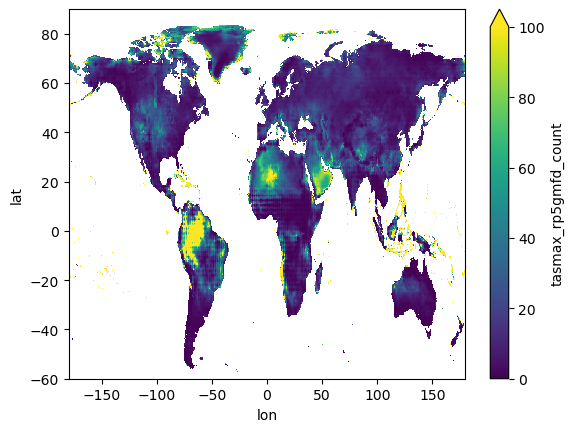

In [20]:
ds.tasmax_rp5gmfd_count.plot(vmax=100)

In [11]:
%%time
################################
# UC on forced response
################################
delayed_res = []
for year in range(2020, 2095):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_forced)(nex_in, [model + '_' + submetric_var for model in nex_models], 
                                           cil_in, cil_models, 
                                           isi_in, [model + '_' + submetric_var for model in isi_models], 
                                           cbp_in, cbp_gard_models, cbp_deep_models,
                                           land_mask,
                                           metric, submetric,
                                           year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_' + submetric_var + '_rp5gmfd.nc')

CPU times: user 1min 54s, sys: 9.03 s, total: 2min 3s
Wall time: 11min 33s


In [12]:
ds = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/uc_results/uc_with_iav/hot_tasmax_rp5gmfd.nc')

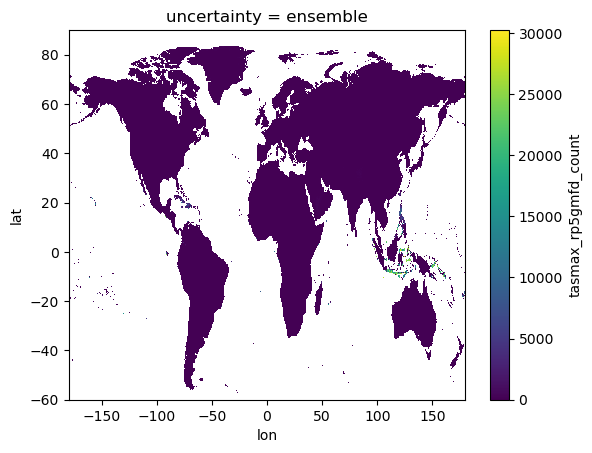

In [16]:
ds.tasmax_rp5gmfd_count.isel(time=10, uncertainty=2).plot()

### Tasmin GMFD RP5

In [23]:
metric = 'hot'
submetric = ['tasmin_rp5gmfd_count', 'tasmin_rp5gmfd_streak']
submetric_var = 'tasmin'

In [24]:
%%time
################################
# Interannual variability
################################
delayed_res = make_delayed_list_iav(metric, submetric, submetric_var)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and average over ensemble + model (ensmod) and ssp
ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_' + submetric_var + '_rp5gmfd_iav.nc')

CPU times: user 24.2 s, sys: 8.01 s, total: 32.2 s
Wall time: 2min 15s


In [25]:
%%time
################################
# UC on forced response
################################
delayed_res = []
for year in range(2020, 2095):
    # Read all ensembles and compute UC
    tmp_res = dask.delayed(uc_forced)(nex_in, [model + '_' + submetric_var for model in nex_models], 
                                           cil_in, cil_models, 
                                           isi_in, [model + '_' + submetric_var for model in isi_models], 
                                           cbp_in, cbp_gard_models, cbp_deep_models,
                                           land_mask,
                                           metric, submetric,
                                           year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_' + submetric_var + '_rp5gmfd.nc')

CPU times: user 1min 33s, sys: 6.92 s, total: 1min 40s
Wall time: 10min 19s
